In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# numpy 임의성 조절
np.random.seed(42)

# 데이터 셋 가지고 오기
dataset = pd.read_csv('dataset/MNIST_preprocessed.csv', sep=',', header=None).values

# 입력, 목표 변수 데이터 셋 나누기
X = dataset[:, 0:784]
Y = dataset[:, 784:]

In [3]:
dataset.shape

(300, 794)

In [4]:
X.shape

(300, 784)

In [5]:
Y.shape

(300, 10)

In [6]:
# training, testing 데이터 셋 나누기
X_train, X_test = X[0:250,], X[250:,]
Y_train, Y_test = Y[0:250,], Y[250:,]

In [7]:
X_train.shape

(250, 784)

In [8]:
X_test.shape

(50, 784)

In [9]:
def sigmoid(x):
    """시그모이드 함수"""
    return 1/(1 + np.exp(-x))


In [10]:
def d_sigmoid(x):
    """시그모이드 미분 함수"""
    return (np.exp(-x))/((np.exp(-x)+1)**2)


In [11]:
def initialize_parameters(neurons_per_layer):
    """신경망의 가중치와 편향을 초기화해주는 함수"""
    
    L = len(neurons_per_layer) - 1  # 입력층을 포함함 층 개수 저장
    parameters = {}
    
    # 1층 부터 L 층까지 돌면서 가중치와 편향 초기화
    for l in range(1, L+1):
        parameters['W' + str(l)] = np.random.randn(neurons_per_layer[l], neurons_per_layer[l-1]) * np.sqrt(1. / neurons_per_layer[l])
        parameters['b' + str(l)] = np.random.randn(neurons_per_layer[l]) * np.sqrt(1. / neurons_per_layer[l])
        
        # 신경망의 가중치와 편향의 값들을 초기화할 때는, 값들의 표준 오차를 1 대신 그 층의 뉴런의 개수의 루트 값과 반비례 하는 값을 사용
        #(신경망이 훨씬 더 빠르게, 잘 학습되기 때문)
        # 그렇게 하기 위해 임의로 초기화한 ll번째 층 가중치와 편향의 모든 원소들에 np.sqrt(1. / neurons_per_layer[l])곱해줌
        
    return parameters

In [12]:
def feed_forward(x, parameters):
    """순전파 함수"""
   
    cache = {'a0': x}
    L = len(parameters) // 2
    
    for l in range(1, L+1):
        # 전 층 뉴런의 출력, 현재 층 뉴런들의 가중치, 편향 데이터를 가지고 온다.
        a_prev = cache['a' + str(l-1)]
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        
        # 데이터로 z와 a를 계산한다.
        z = W @ a_prev + b
        a = sigmoid(z)

        # 결과 값을 캐쉬에 저장한다.
        cache['z' + str(l)] = z
        cache['a' + str(l)] = a
                
    return a, cache

In [13]:
def compute_accuracy(x_val, y_val, parameters):
    """테스트 데이터에서 예측값들의 성능을 계산하는 함수"""
    predictions = []

    for x, y in zip(x_val, y_val):
        output, _ = feed_forward(x, parameters)
        pred = np.argmax(output)
        predictions.append(pred == np.argmax(y))

    return np.mean(predictions)

In [14]:
def compute_loss(x_val, y_val, parameters):
    """학습 데이터에서 현재 모델의 손실을 계산하는 함수"""
    loss = 0
    
    for x, y in zip(x_val, y_val):
        output, _ = feed_forward(x, parameters)
        loss += np.mean((output - y)**2) / 2
        
    return loss / len(x_val)

In [15]:
def back_prop(prediction, y, cache, parameters):
    """역전파 함수"""
    gradients = {}
    L = len(cache) // 2
    da = (prediction - y) / y.shape[0]
    
    for layer in range(L, 0, -1):
        # 역전파 행렬 연산을 사용해서 각 요소에 대한 편미분 계산
        db = d_sigmoid(cache['z' + str(layer)]) * da
        dW = np.outer(db, cache['a' + str(layer-1)])
        da = parameters['W'+str(layer)].T @ db
        
        # 계산한 편미분 값들을 저장
        gradients['dW' + str(layer)] = dW
        gradients['db' + str(layer)] = db
    
    # 계산한 편미분 값들 리턴
    return gradients

In [16]:
def update(parameters, gradients, alpha, m):
    """계산한 경사로 가중치와 편향을 업데이트 하는 함수"""
    L = len(parameters) // 2
    
    for layer in range(1, L+1):
        parameters['W'+str(layer)] -= alpha * gradients['dW'+str(layer)] / m
        parameters['b'+str(layer)] -= alpha * gradients['db'+str(layer)] / m
    
    return parameters

In [17]:
def train_nn(X_train, Y_train, X_test, Y_test, neurons_per_layer, epoch, alpha):
    """신경망을 학습시키는 함수"""
    parameters = initialize_parameters(neurons_per_layer)
    loss_list = []
    m = X_train.shape[0]
    
    # epoch 번 경사 하강을 한다
    for i in range(epoch):
        parameters_copy = parameters.copy()
        
        # 모든 이미지에 대해서 경사 계산 후 평균 계산
        for x, y in zip(X_train, Y_train):
            prediction, cache = feed_forward(x, parameters)
            gradients = back_prop(prediction, y, cache, parameters)
            parameters_copy = update(parameters_copy, gradients, alpha, m)
        
        # 가중치와 편향 실제로 업데이트
        parameters = parameters_copy
        loss_list.append(compute_loss(X_train, Y_train, parameters))
        print('{}번째 경사 하강, 테스트 셋에서 성능: {}'.format(i+1, round(compute_accuracy(X_test, Y_test, parameters), 2)))     
            
    return loss_list, parameters


In [18]:
neurons_per_layer = [784, 128, 64, 10]
parameters = initialize_parameters(neurons_per_layer)

loss_list, parameters = train_nn(X_train, Y_train, X_test, Y_test, neurons_per_layer, 25, 300)

1번째 경사 하강, 테스트 셋에서 성능: 0.16
2번째 경사 하강, 테스트 셋에서 성능: 0.18
3번째 경사 하강, 테스트 셋에서 성능: 0.36
4번째 경사 하강, 테스트 셋에서 성능: 0.54
5번째 경사 하강, 테스트 셋에서 성능: 0.64
6번째 경사 하강, 테스트 셋에서 성능: 0.64
7번째 경사 하강, 테스트 셋에서 성능: 0.64
8번째 경사 하강, 테스트 셋에서 성능: 0.68
9번째 경사 하강, 테스트 셋에서 성능: 0.68
10번째 경사 하강, 테스트 셋에서 성능: 0.7
11번째 경사 하강, 테스트 셋에서 성능: 0.7
12번째 경사 하강, 테스트 셋에서 성능: 0.7
13번째 경사 하강, 테스트 셋에서 성능: 0.7
14번째 경사 하강, 테스트 셋에서 성능: 0.7
15번째 경사 하강, 테스트 셋에서 성능: 0.76
16번째 경사 하강, 테스트 셋에서 성능: 0.76
17번째 경사 하강, 테스트 셋에서 성능: 0.78
18번째 경사 하강, 테스트 셋에서 성능: 0.8
19번째 경사 하강, 테스트 셋에서 성능: 0.8
20번째 경사 하강, 테스트 셋에서 성능: 0.8
21번째 경사 하강, 테스트 셋에서 성능: 0.8
22번째 경사 하강, 테스트 셋에서 성능: 0.8
23번째 경사 하강, 테스트 셋에서 성능: 0.8
24번째 경사 하강, 테스트 셋에서 성능: 0.8
25번째 경사 하강, 테스트 셋에서 성능: 0.8


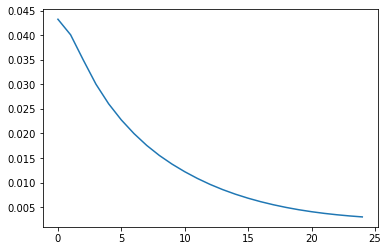

In [19]:

plt.plot(loss_list)
plt.show()